### Load Data and Test Likelihood Function

In [1]:
import pandas as pd
import numpy as np
from skyfield.data import mpc
from skyfield.api import load
from orbit_mcmc_funs import epoch2jd, chi2fun, ln_like

# Asteroid
target = '2012FN62'
# Load orbital elements
with load.open(f'MPC/MPCORB.{target}.DAT') as f:
    minor_planets = mpc.load_mpcorb_dataframe(f)
row = minor_planets.loc[0].copy() # Create an explicit copy

# template orbital elements (Panda Series)
elms = row.copy()

# array of truth element
truths = np.array([row.semimajor_axis_au,
                   row.eccentricity,
                   row.inclination_degrees,
                   row.longitude_of_ascending_node_degrees,
                   row.argument_of_perihelion_degrees,
                   row.mean_anomaly_degrees])
# MPC epoch_packed to JD
truths_T = epoch2jd(row.epoch_packed)

# load csv file
datafile = '2012FN62_s150_n3'
cat = pd.read_csv(f'sim_data/{datafile}.csv')
jds = np.array(cat.JD)
ras = np.array(cat.RA_obs)
decs = np.array(cat.Dec_obs)
perr = np.array(cat.perr)

# parameter names and boundaries
params = ['$a$','$e$','$i$','$\Omega$', '$\omega$', '$MA$']
bounds = np.array([[2.0,   0,  0,   0,  0,    0],
                   [3.5, 0.9, 30, 360, 360, 360]])

# test Likelihood and Chi^2 functions
# Set print options to display 2 decimal places
np.set_printoptions(formatter={'float': '{:.2f}'.format})
print(f"(a,e,i,Omega,omega,MA) @ Epoch: {truths} @ {truths_T}")
print(ln_like(truths,bounds,elms,jds,ras,decs,perr))
print(chi2fun(truths,elms,jds,ras,decs,perr))

(a,e,i,Omega,omega,MA) @ Epoch: [3.27 0.62 10.01 147.97 142.47 49.03] @ 2460800.5
-0.7786524360374111
1.5573048720748222


### AMOEBA

Use a downhill simplex method with simulated annealing (`amoeba_sa`) 
to search for the best-fit orbital elements in the 6-dimensional 
parameter space. 

In [2]:
""" 
Computing Time on M2 Macbook Air: 
    2m for 10 iterations of nmax = 1000 steps
"""
from amoeba import amoeba_sa

def func(p): return chi2fun(p,elms,jds,ras,decs,perr)

# Parameters for simulated annealing
niter = 10
cooling = 1.0 / niter
temp0 = len(jds)
scl0 = (bounds[1,:]-bounds[0,:])/3
p0 = (bounds[1,:]+bounds[0,:])/2

# Set print options to display 2 decimal places
np.set_printoptions(formatter={'float': '{:.2f}'.format})

# truth chisq and initial guess chisq
print(f"(a,e,i,Omega,omega,MA): {truths}")
print(f"Truth chi-squared: {func(truths)}")
print(f"(a,e,i,Omega,omega,MA): {p0}")
print(f"Initial chi-squared: {func(p0)}")

# Run simulated annealing
for i in range(niter):
    temp = temp0 * (1.0 - cooling * i)
    scl = scl0 * (1.0 - cooling * i / 2.0)
    best_params, result = amoeba_sa(1e-5, function_name=func, 
                                    p0=p0, scale=scl, 
                                    upper=bounds[1,:], lower=bounds[0,:],
                                    temperature=temp, nmax=1000)
    p0 = best_params.copy()  # Use the best parameters as the starting point for the next iteration
    # show progress
    print(f"(a,e,i,Omega,omega,MA): {best_params}")
    print(f"Minimum chi-squared: {np.min(result['chi2'])}")

(a,e,i,Omega,omega,MA): [3.27 0.62 10.01 147.97 142.47 49.03]
Truth chi-squared: 1.5573048720748222
(a,e,i,Omega,omega,MA): [2.75 0.45 15.00 180.00 180.00 180.00]
Initial chi-squared: 453243607412.23956
(a,e,i,Omega,omega,MA): [2.70 0.64 10.07 145.00 132.58 63.09]
Minimum chi-squared: 28038.962892495598
(a,e,i,Omega,omega,MA): [3.21 0.62 10.01 147.69 141.71 50.08]
Minimum chi-squared: 184.51879712567424
(a,e,i,Omega,omega,MA): [3.22 0.62 10.01 147.76 141.71 50.04]
Minimum chi-squared: 91.12822658274094
(a,e,i,Omega,omega,MA): [3.22 0.62 10.01 147.76 141.70 50.03]
Minimum chi-squared: 88.50865397046825
(a,e,i,Omega,omega,MA): [3.22 0.62 10.01 147.77 141.72 50.01]
Minimum chi-squared: 85.0608448379893
(a,e,i,Omega,omega,MA): [3.22 0.62 10.01 147.78 141.75 49.97]
Minimum chi-squared: 78.32429109744314
(a,e,i,Omega,omega,MA): [3.22 0.62 10.01 147.78 141.75 49.97]
Minimum chi-squared: 78.32429109744314
(a,e,i,Omega,omega,MA): [3.26 0.62 10.01 147.94 142.35 49.18]
Minimum chi-squared: 0.6581

### Run MCMC sampler

In [4]:
""" 
Computing Time on M2 Macbook Air: 
    10m for nsteps = 10000 and nwalkers = 16

Multiprocessing with 8 CPU cores is 5x faster than single processing:

    multiprocessing 
    100%|██████████| 1000/1000 [00:52<00:00, 19.06it/s]
    single processing
    100%|██████████| 1000/1000 [04:09<00:00,  4.01it/s]
"""

import multiprocessing, emcee, os
import numpy as np

# prep for multithreading
multiprocessing.set_start_method("fork")   # fork: copy a Python process from an existing process.
os.environ["OMP_NUM_THREADS"] = "1"        # disable automatic parallelization in NumPy

# need 8500 steps for chains to converge: nsteps/max(tau) > 50
nsteps = 10000 
nrepeat = 1
converge_check = True

emcfile = f'results/{datafile}.h5'
#if os.path.exists(emcfile): os.remove(emcfile)

""" initial starting positions of the walkers """
cnter = best_params # starting around the amoeba best-fit position
print(cnter)
ncpu = 8
ndim = len(bounds[0,:])
nwalkers = ncpu*int(np.ceil(2.5*ndim/ncpu)) 
scale = (bounds[1,:]-bounds[0,:])/50
pos = cnter + scale*(np.random.normal(size=(nwalkers, ndim)))
# clip initial positions outside of bounds
for i in range(ndim):
    pos[:,i] = np.clip(pos[:,i], bounds[0,i], bounds[1,i]) 

for irepeat in range(1,nrepeat+1):
    print(f'\nThis is {irepeat=} out of {nrepeat=}')
    # set up backend to save MCMC samples
    backend = emcee.backends.HDFBackend(emcfile)
    if not os.path.exists(emcfile): 
        print(f'Reset backend because {emcfile} not present')
        backend.reset(nwalkers, ndim)
        print(f'Start MCMC from initial random positions')
        instate = pos
        chainexist = False
    else: 
        print(f'Start MCMC from where left off the last time in {emcfile}')
        instate = None
        chainexist = True

    # set up sampler 
    with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                ln_like, args=(bounds,elms,jds,ras,decs,perr), 
                pool=pool, backend=backend)
        # check if chain is already long enough
        if chainexist and converge_check:
            chainshape = sampler.get_chain().shape
            tau = sampler.get_autocorr_time(quiet=True)
            flat_samples = sampler.get_chain(flat=True) 
            log_probs = sampler.get_log_prob(flat=True)
            map_idx = np.argmax(log_probs)  # Index of the MAP sample
            map_params = flat_samples[map_idx]   # Parameters at MAP
            print(f"MAP: {log_probs[map_idx]}, parameters: {map_params}")
            if chainshape[0] > 50*np.max(tau): 
                print("[Break]: Chain length already exceeds 50x Auto-correlation Time")
                break 
        # start walking
        sampler.run_mcmc(instate, nsteps, progress=True)


[3.26 0.62 10.01 147.95 142.40 49.12]

This is irepeat=1 out of nrepeat=1
Reset backend because results/2012FN62_s150_n3.h5 not present
Start MCMC from initial random positions


100%|██████████| 10000/10000 [08:59<00:00, 18.52it/s]


### Corner Plots to Show Covariances amongst Orbital Elements

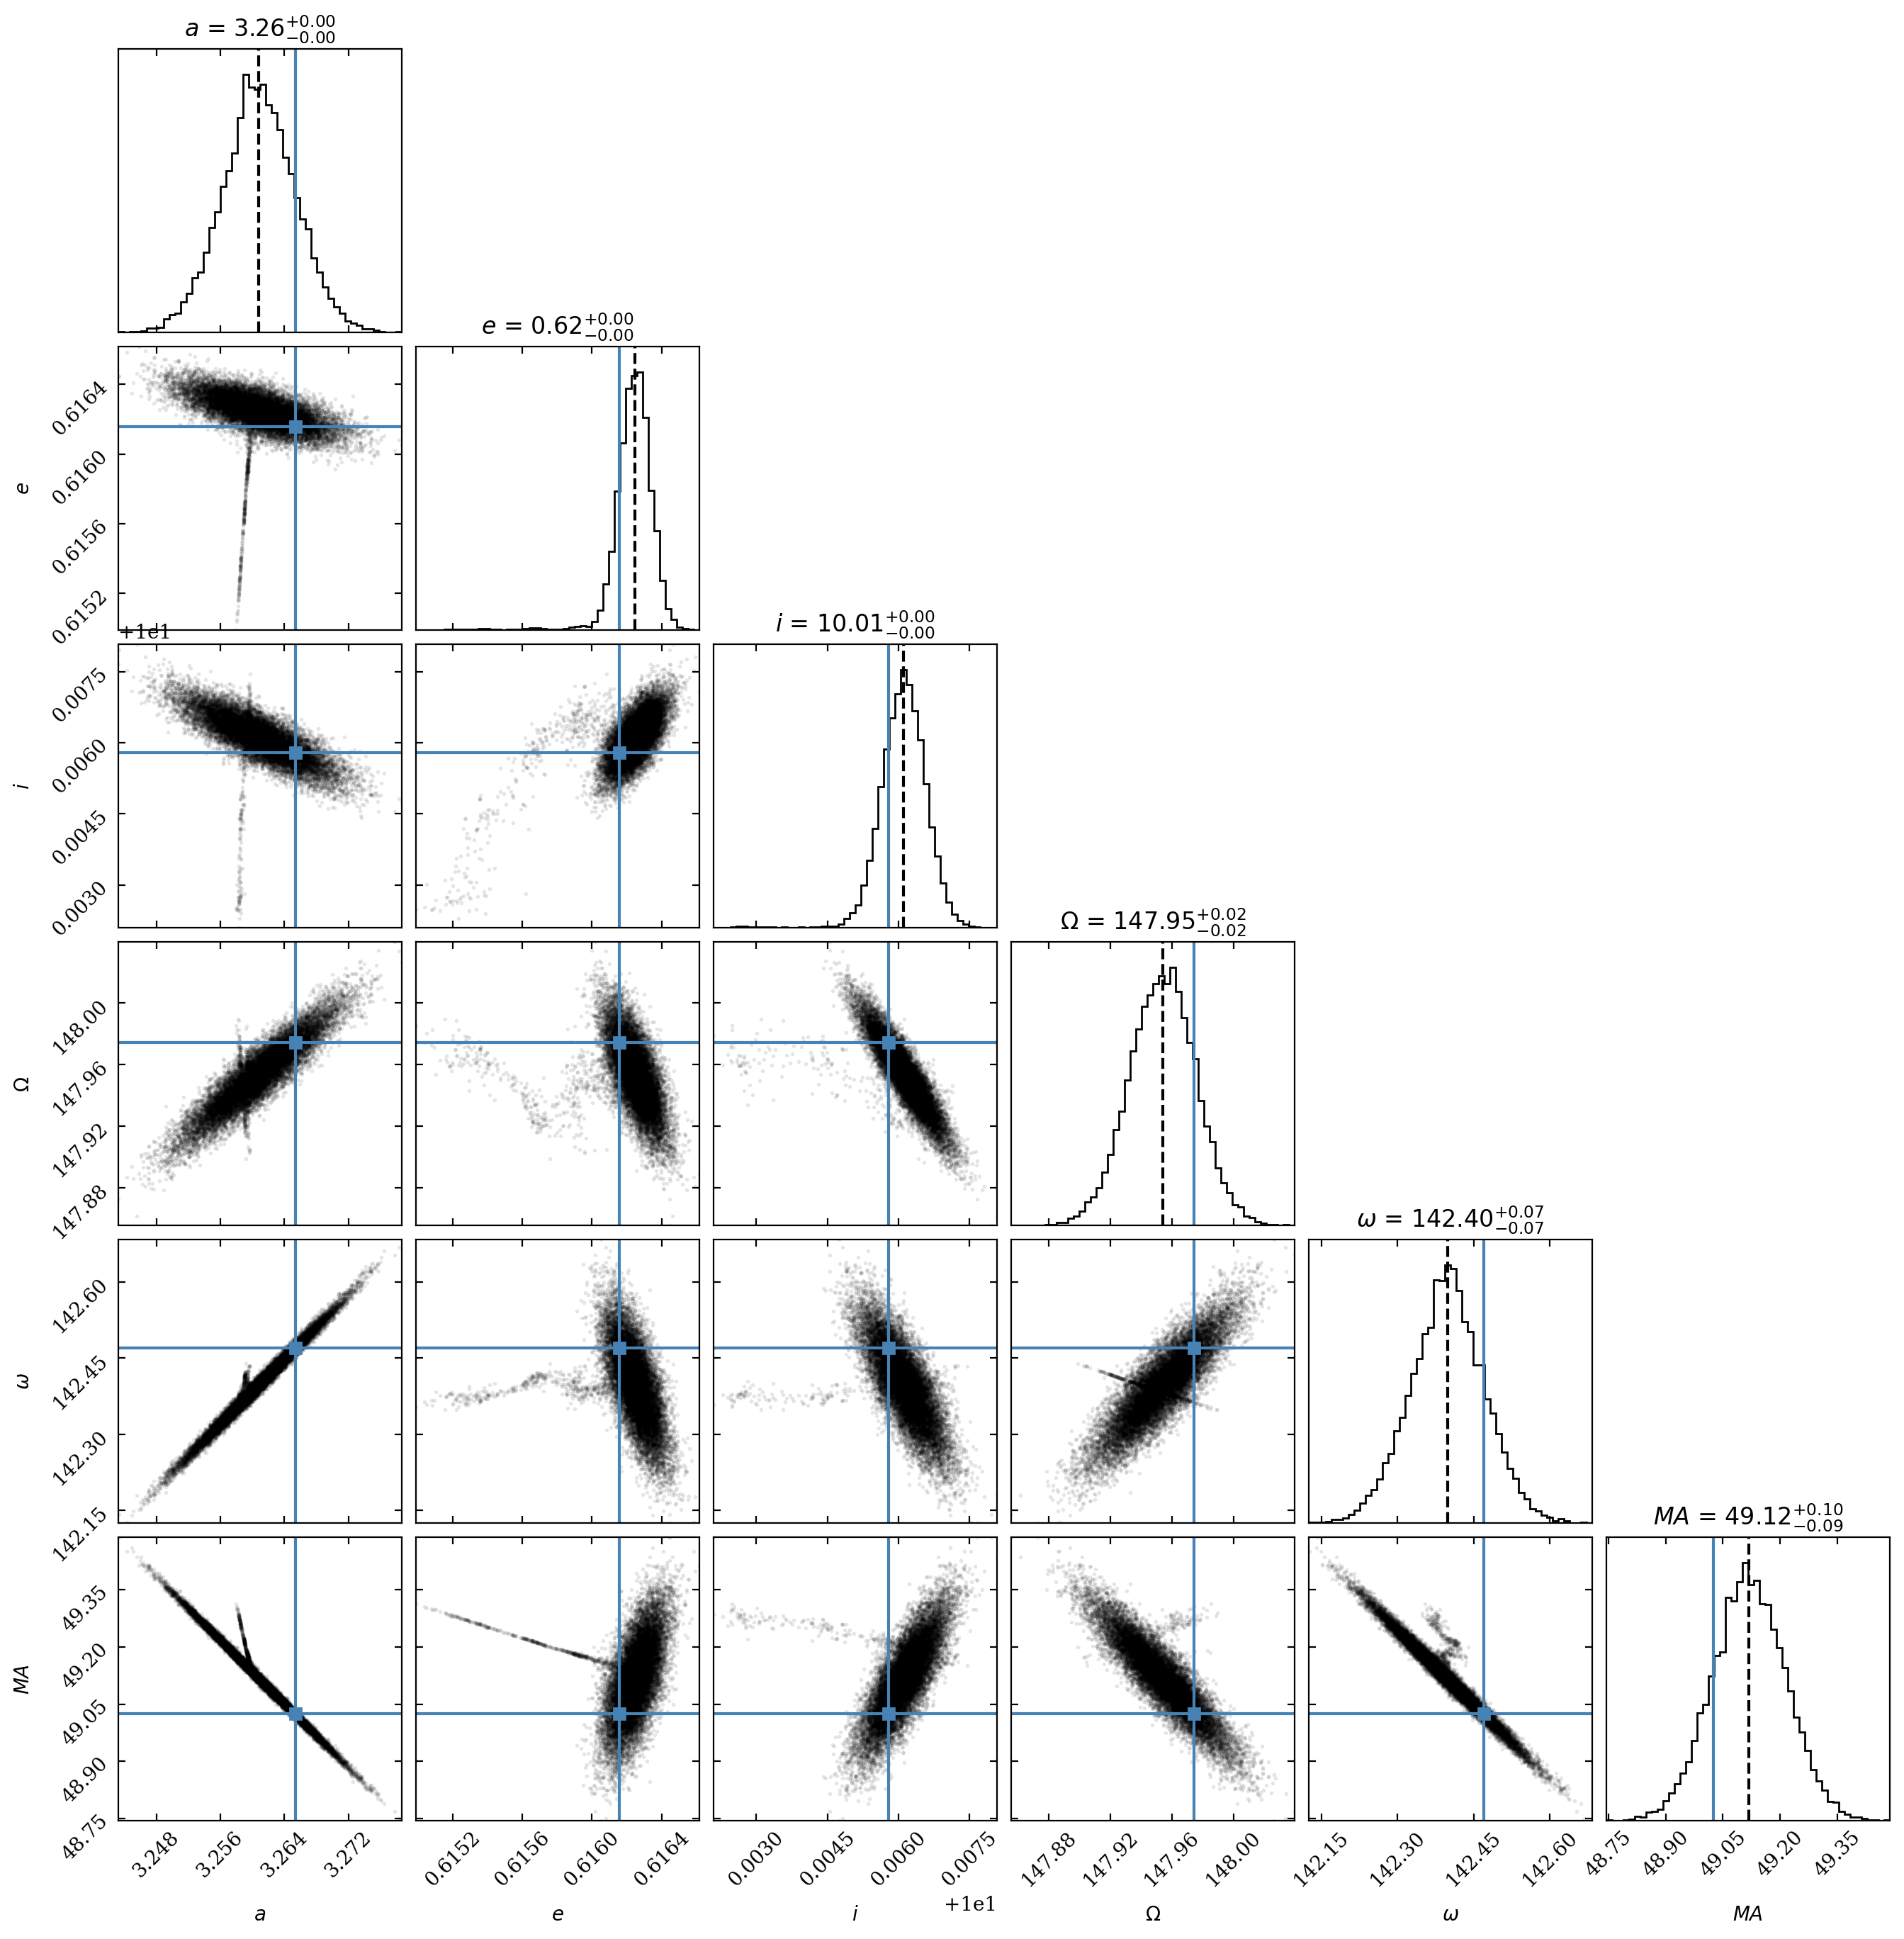

In [7]:
""" make a corner plot over full bounded range """
import emcee, corner
import matplotlib.pyplot as plt

sampler = emcee.backends.HDFBackend(emcfile)
nstep, nwalker, ndim = sampler.get_chain().shape
# use trimmed, thinned, flattened sample for corner plots
tau = sampler.get_autocorr_time(quiet=True)
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
mids = np.array([np.percentile(flat_samples[:,i],50) for i in range(ndim)])

_ = corner.corner(flat_samples, labels=params, truths=truths,
        title_quantiles=[0.16,0.50,0.84], quantiles=[0.50],
        show_titles=True, plot_contours=False, plot_density=False, bins=50)
plt.savefig(f'{emcfile.replace(".h5","")}_{nstep}_zoom.png', bbox_inches='tight')

In [ ]:
""" make a corner plot over the full ranges of parameter bounds """
#_ = corner.corner(flat_samples, labels=params, truths=truths,
#        title_quantiles=[0.16,0.50,0.84], quantiles=[0.50],
#        show_titles=True, plot_contours=False, plot_density=False, bins=50,
#        range=list(zip(bounds[0],bounds[1])))
#plt.savefig(f'{emcfile.replace(".h5","")}_{nstep}.png', bbox_inches='tight')